# Lecture 5b Notebook - Resampling Methods (Part 2)

---

## Resampling Methods

Problems arise when we cannot directly sample from the true data generating process.

In practice, we usually only have access to a single dataset. In which case, we can use <b>resampling methods</b> to estimate the sampling distribution of our estimates/statistics.

See Chapter 5 of [`ISLR`](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf) for more details.

### Bootstrap

The idea behind <b>bootstrap</b> is simple: we can "simulate" new datasets by repeatedly sampling observations from the original dataset (with replacement). 

We can then use the approach showed above as a method for estimating the sampling distribution of our statistics.

In general, the advantages of bootstrap are very marginal when used on traditional statistical models like linear regression. This is because a lot of the theoretical work has already been done for these models, so most statistical libraries can give you these estimates automatically.

Where bootstrap really shines is when it is applied to models that are not necessarily statistical in nature (e.g. most machine learning models).

---

#### Example. Family Income and Expenditure Survey (FIES 2015)

For this section, we will be using the <b>Family Income and Expenditure Survey</b> (FIES) which is a study conducted by the Philippine Statistics Authority (PSA) every 3 years. Here's a brief description of the dataset from the PSA website:

`Provides data on family income and expenditure which include among others levels of consumption by item of expenditure as well sources of income in cash and in kind.`

`Specifically discusses levels of living and disparities in income and spending patterns of families belonging to different income groups. Also includes related information such as number of family members employed for pay or profit (or as wage, salary, or own-account workers); occupation, age, and educational attainment of household head; and other housing characteristics.`

Very cool.

Specifically, we'll focus on the total annual income and expenditures figures per household.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression

plt.rcParams["figure.figsize"] = (10,10)

df = pd.read_csv('fies_2015_toinc_tottex.csv')

df.head(5)

,toinc,ttotex
0,480332,282828
1,198235,185266
2,82785,92814
3,107589,111056
4,189322,152047


In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df.describe()

,toinc,ttotex
count,41544.00,41544.00
mean,247555.58,197815.21
std,286880.52,184389.45
min,11285.00,9988.00
25%,104895.00,93150.25
50%,164079.50,142364.00
75%,291138.50,237595.25
max,11815988.00,3394720.00


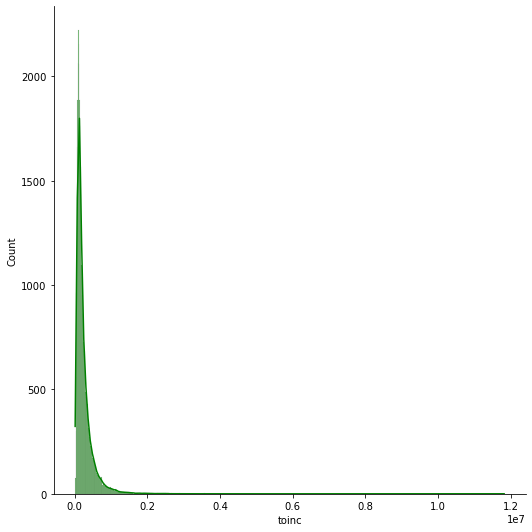

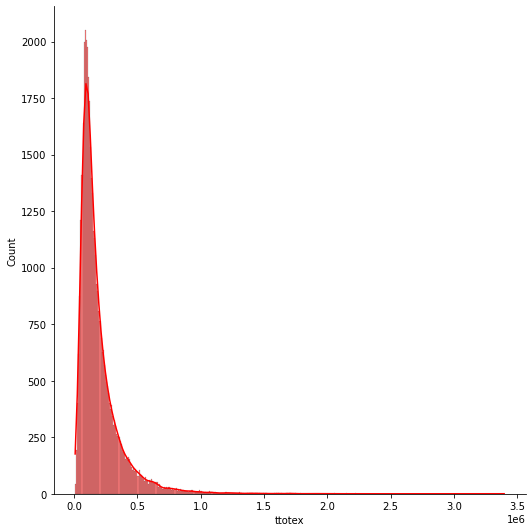

In [3]:
sns.displot(df['toinc'], color='g', kde=True, height=7.5, aspect=1)
plt.show()

sns.displot(df['ttotex'], color='r', kde=True, height=7.5, aspect=1)
plt.show()

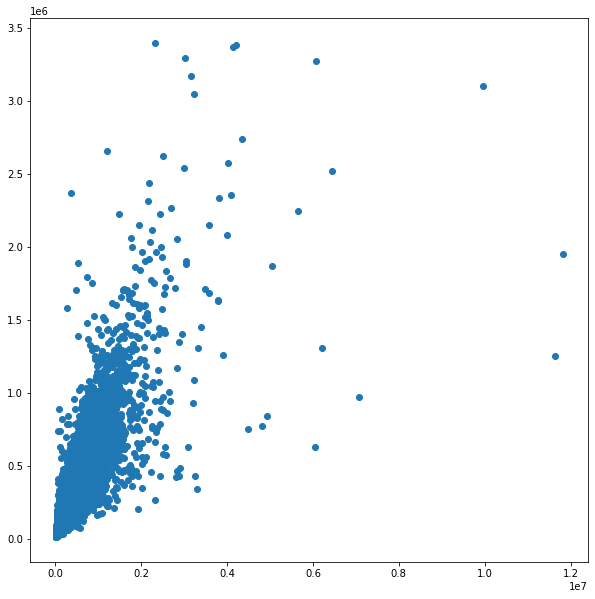

In [4]:
plt.scatter(df['toinc'], df['ttotex'])
plt.show()

A common pre-processing technique you can use for non-negative data is to perform a log transformation $\log(X)$. We usually do this for variables that represent some form of money (e.g. income, prices, etc.). 

In this example, let's suppose that we are trying to predict expenditure using income.

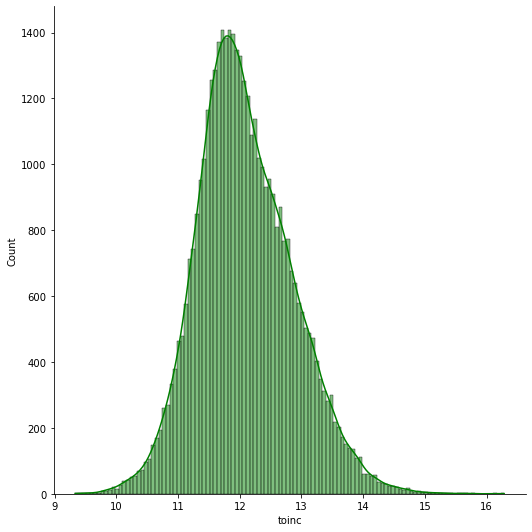

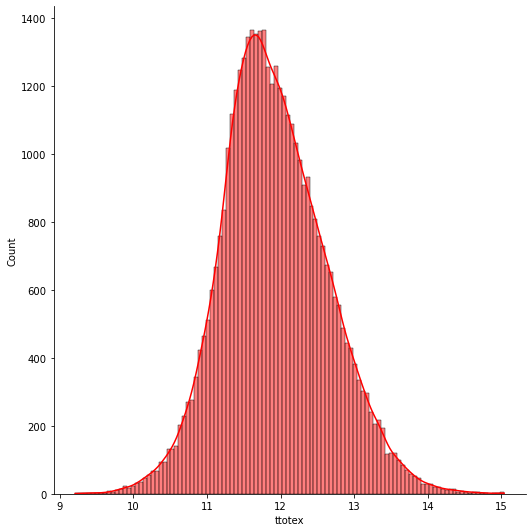

In [5]:
log_inc = np.log(df['toinc'])
log_exp = np.log(df['ttotex'])

sns.displot(log_inc, color='g', kde=True, height=7.5, aspect=1)
plt.show()

sns.displot(log_exp, color='r', kde=True, height=7.5, aspect=1)
plt.show()

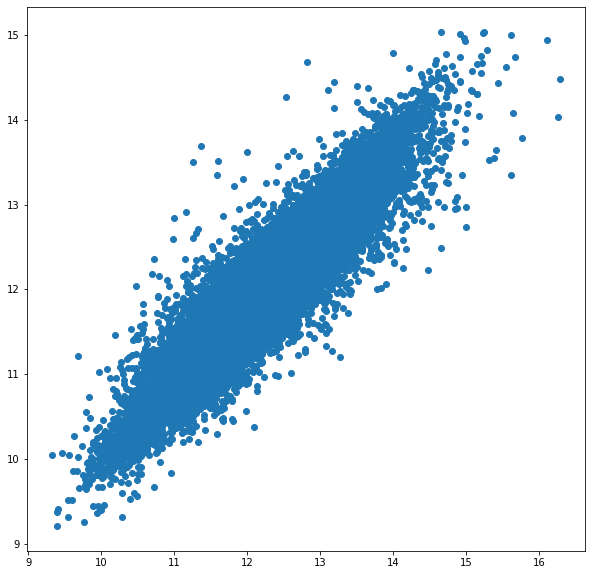

In [6]:
plt.scatter(log_inc, log_exp)
plt.show()

beta1_hat = 0.8587817448416647
beta0_hat = 1.5427605877307915
sigma_hat = 0.2557181875955577


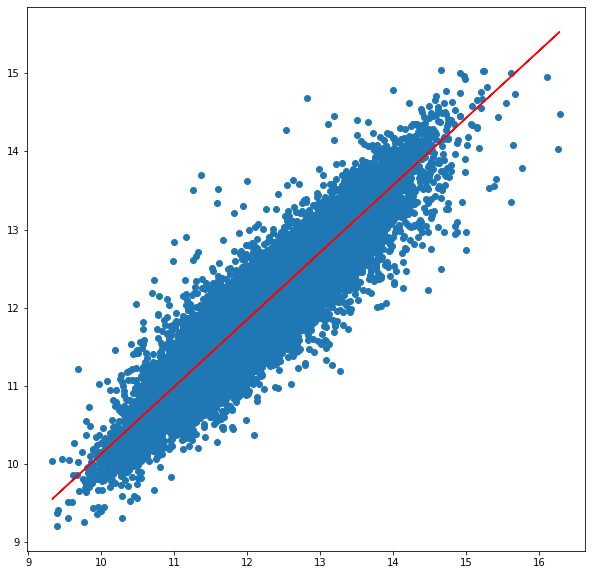

In [7]:
# original dataset
x = log_inc.to_numpy().reshape(-1, 1)
y = log_exp.to_numpy()

model = LinearRegression().fit(x, y)
y_hat = model.predict(x)
resid = y - y_hat

print('beta1_hat =', model.coef_[0])
print('beta0_hat =', model.intercept_)
print('sigma_hat =', np.std(resid))

plt.scatter(x, y)
plt.plot(x, y_hat, color='r')
plt.show()

Now let's use bootstrap to estimate the sampling distributions of our estimates.

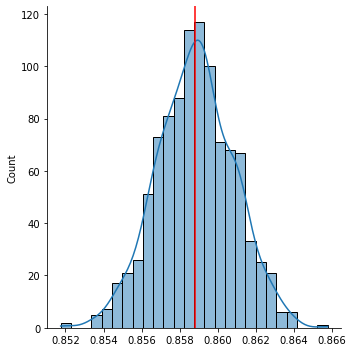

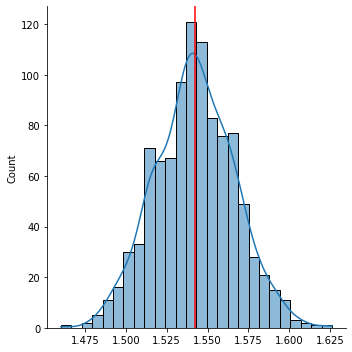

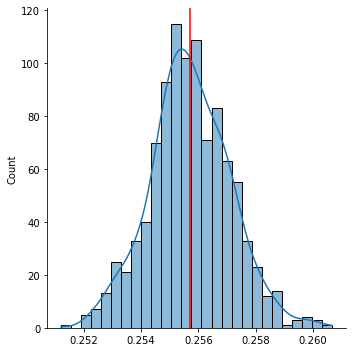

In [8]:
# hyperparameter
n = log_inc.shape[0]
sim_size = 1000

# estimate sampling dist
# put my estimates here
beta1_hat_vec = []
beta0_hat_vec = []
sigma_hat_vec = []

for i in range(sim_size):
    
    # bootstrap - sample with replacement (remember that x,y are paired, DO NOT sample x and y separately)
    samp_ind = np.random.choice(range(n), size=n, replace=True)
    x = log_inc[samp_ind].to_numpy().reshape(-1, 1)
    y = log_exp[samp_ind].to_numpy()
    
    # estimate
    model = LinearRegression().fit(x, y)
    resid = y - model.predict(x)
    
    beta1_hat_vec.append(model.coef_[0])
    beta0_hat_vec.append(model.intercept_)
    sigma_hat_vec.append(np.std(resid))
    
sns.displot(beta1_hat_vec, kde=True)
plt.axvline(np.mean(beta1_hat_vec), c='red')
plt.show()

sns.displot(beta0_hat_vec, kde=True)
plt.axvline(np.mean(beta0_hat_vec), c='red')
plt.show()

sns.displot(sigma_hat_vec, kde=True)
plt.axvline(np.mean(sigma_hat_vec), c='red')
plt.show()

In [9]:
# 95% conf int estimate
b1_conf_int = np.nanquantile(beta1_hat_vec, [0.025, 0.975])
print(' beta1_hat =', b1_conf_int)

b0_conf_int = np.nanquantile(beta0_hat_vec, [0.025, 0.975])
print(' beta0_hat =', b0_conf_int)

sigma_conf_int = np.nanquantile(sigma_hat_vec, [0.025, 0.975])
print(' sigma_hat =', sigma_conf_int)

 beta1_hat = [0.85484855 0.86280418]
 beta0_hat = [1.49443542 1.59017593]
 sigma_hat = [0.25293758 0.25857916]


We can also calculate the statistics automatically using `statsmodels`.

In [10]:
x = sm.add_constant(x)

model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                 2.865e+05
Date:                Tue, 27 Jul 2021   Prob (F-statistic):               0.00
Time:                        04:15:43   Log-Likelihood:                -1939.8
No. Observations:               41544   AIC:                             3884.
Df Residuals:                   41542   BIC:                             3901.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5238      0.019     78.273      0.0

---

#### Example. Generating Prediction Intervals using Bootstrap

Note that predictions are also statistics, they also have an associated distributiuon that we can estimate.

A confidence interval on a prediction is called <b>prediction interval</b> (PI). It gives us an idea about the variability or uncertainty around a particular prediction. Very useful to examine especially from a risk analysis perspective.

For a simple parametric model like linear regression, we can actually calculate the PIs analytically. In general though, we can use bootstrap to estimate prediction intervals for <u>any</u> model. This is especially useful when we use ML models.

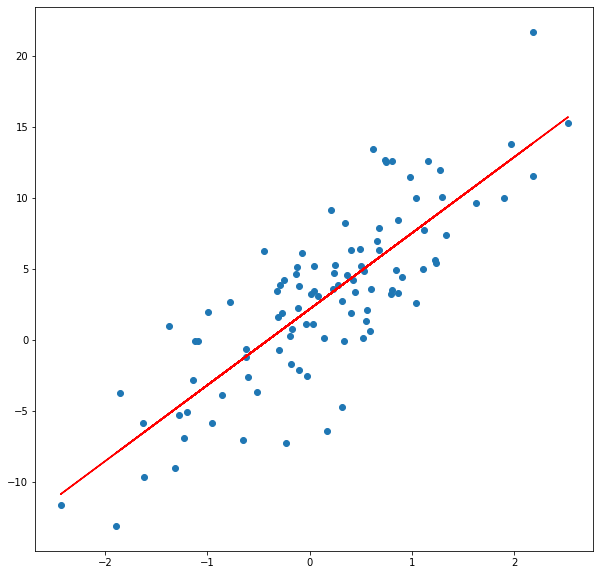

In [11]:
# set seed
np.random.seed(1)

# hyperparameters
n = 100

# true parameters
mu, sigma = 0, 4
b0 = 2
b1 = 5

# observed data
e = np.random.normal(mu, sigma, n)
x = np.random.normal(0, 1, n)
y = b0 + b1*x + e

# fit linear model
model = LinearRegression().fit(x.reshape(-1, 1), y)
y_hat = model.predict(x.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x, y)
plt.plot(x, y_hat, color='r')
plt.show()

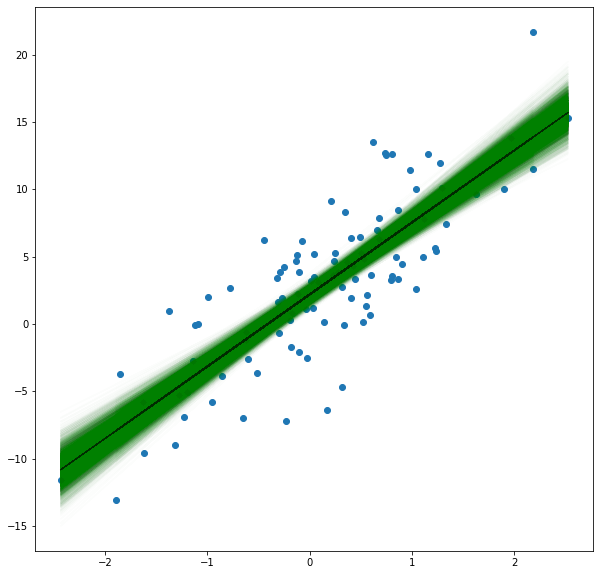

In [12]:
# for plotting a continous prediction space
x_range = np.arange(x.min(), x.max()+0.1, 0.1).reshape(-1, 1)

plt.scatter(x, y)
plt.plot(x, y_hat, color='r')

# hyperparameter
sim_size = 5_000

# estimate sampling dist
beta1_hat_vec = []
beta0_hat_vec = []
sigma2_hat_vec = []
pred_vec = []
for i in range(sim_size):
    
    # bootstrap - sample with replacement (remember that X,Y are paired, DO NOT sample X & Y separately)
    samp_ind = np.random.choice(range(n), size=n, replace=True)
    x_boot = x[samp_ind].reshape(-1, 1)
    y_boot = y[samp_ind]
    
    # estimate
    model = LinearRegression().fit(x_boot, y_boot)
    
    beta1_hat = model.coef_[0]
    beta0_hat = model.intercept_
    
    # remember that we are trying to predict the original X (not the bootstrapped X)
    y_hat = beta0_hat + beta1_hat*x
    
    beta1_hat_vec.append(beta1_hat)
    beta0_hat_vec.append(beta0_hat)
    pred_vec.append(beta0_hat + beta1_hat*x_range.flatten())
    
    plt.plot(x, y_hat, 'g-', alpha = 0.01)
    
plt.show()

pred_vec = np.array(pred_vec)
pi_95 = np.nanquantile(pred_vec, q=[0.025, 0.975], axis=0)

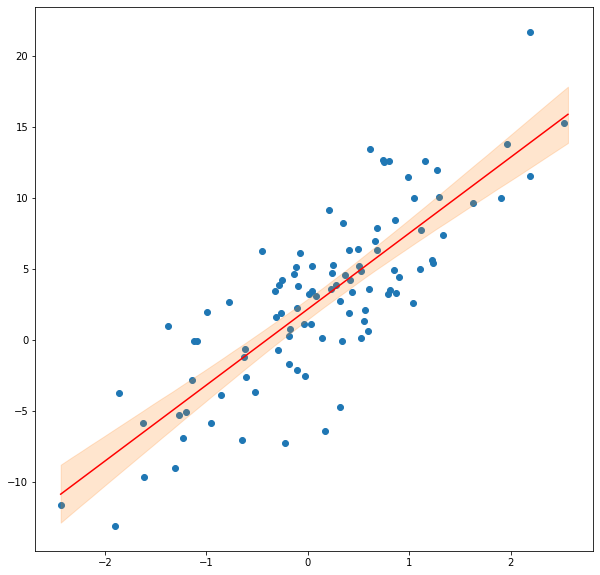

In [14]:
model = LinearRegression().fit(x.reshape(-1, 1), y)

fig, ax = plt.subplots()
plt.scatter(x, y)
plt.plot(x_range, model.predict(x_range), color='r')
ax.fill_between(x_range.flatten(), pi_95[0, :], pi_95[1, :], color='tab:orange', alpha=0.2)
plt.show()

---

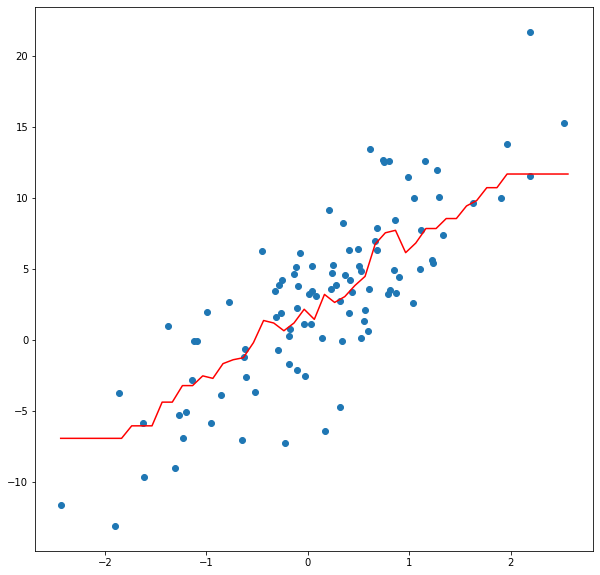

In [15]:
from sklearn.neighbors import KNeighborsRegressor

# fit knn
model = KNeighborsRegressor(n_neighbors=10).fit(x.reshape(-1, 1), y)
y_hat = model.predict(x.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(10, 10))
plt.scatter(x, y)
plt.plot(x_range, model.predict(x_range), color='r')
plt.show()

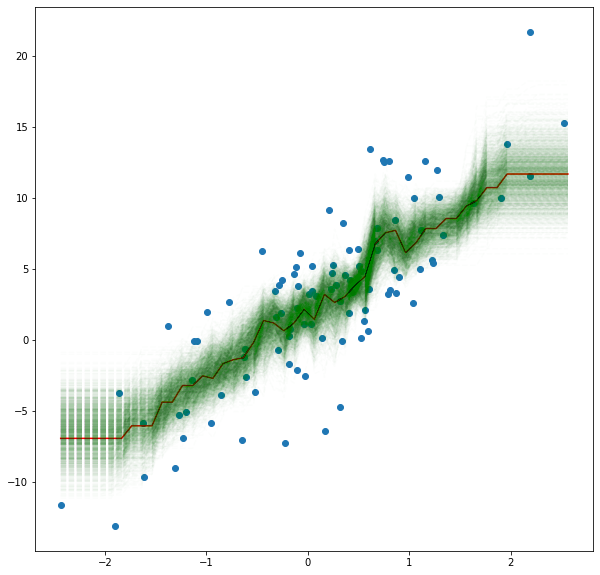

In [16]:
plt.scatter(x, y)
plt.plot(x_range, model.predict(x_range), color='r')

# hyperparameter
sim_size = 2000

# estimate sampling dist
pred_vec = []
for i in range(sim_size):
    
    # bootstrap - sample with replacement (remember that X,Y are paired, DO NOT sample X & Y separately)
    samp_ind = np.random.choice(range(n), size=n, replace=True)
    x_boot = x[samp_ind].reshape(-1, 1)
    y_boot = y[samp_ind]
    
    # fit knn
    model = KNeighborsRegressor(n_neighbors=10).fit(x_boot, y_boot)
    
    pred_vec.append(model.predict(x_range))
    
    plt.plot(x_range, model.predict(x_range), 'g--', alpha = 0.01)
    
plt.show()

pred_vec = np.array(pred_vec)
pi_95 = np.nanquantile(pred_vec, q=[0.025, 0.975], axis=0)

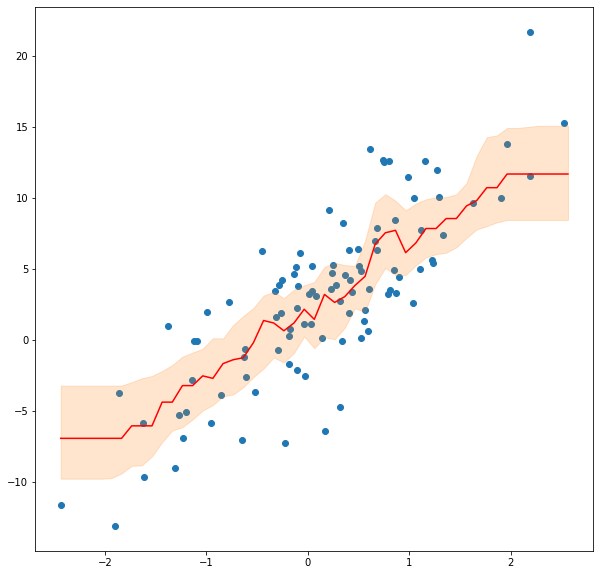

In [17]:
model = KNeighborsRegressor(n_neighbors=10).fit(x.reshape(-1, 1), y)

fig, ax = plt.subplots()
plt.scatter(x, y)
plt.plot(x_range, model.predict(x_range), color='r')
ax.fill_between(x_range.flatten(), pi_95[0, :], pi_95[1, :], color='tab:orange', alpha=0.2)
plt.show()